# 通道策略
*用Python量化你的技术分析*

## 目录
- 通道是什么？
- 不同通道是怎么计算的？
- 通道如何用图表显示？
- 如何用通道构建策略？

## 通道是什么？
通道突破是技术分析中一个判断趋势的重要方法，其观念在于市场价格穿透了之前的价格压力或支撑，继而形成一股新的趋势，而交易策略的目标即是在突破发生时能够确认并建立仓位以获取趋势的利润。

## 不同通道是怎么计算的？
---
### 1. 均线百分比通道

$Upper = MA*1.03$

$lower = MA*0.97$

---

### 2. 布林带通道
$upper = MA+2\sigma$

$lower = MA-2\sigma$

---

### 3. 平均波幅通道
$upper = MA + ATR$

$lower = MA - ATR$

---

### 4. 高低价通道
$upper = Max(High,20)$

$lower = Min(low,20)$

## 通道如何用图表显示？

In [1]:
from jaqs.data import DataView
from jaqs.data import RemoteDataService
import os
import numpy as np
import talib as ta
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

dataview_folder = '../Factor'
dv = DataView()
dv.load_dataview(dataview_folder)

Dataview loaded successfully.


In [2]:
def change_index(df):
    df.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , df.index))
    return df
data = change_index(dv.get_ts('close_adj').loc[20170105:])

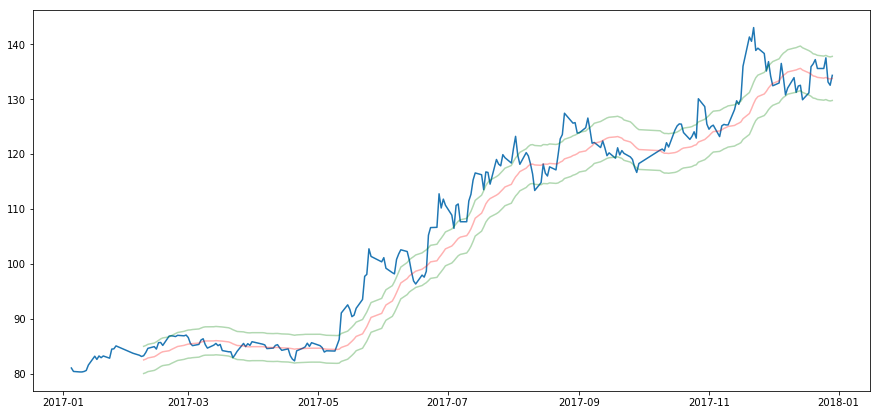

In [3]:
#均线百分比通道
middleband = ta.abstract.MA(data, timeperiod=20, price='600036.SH')
upperband = middleband*1.03
lowerband = middleband*0.97
data_B = pd.concat([middleband, upperband , lowerband], axis=1)
data_B.columns = ['middleband','upperband','lowerband']

plt.figure(figsize=(15,7))
plt.plot(data['600036.SH'])
plt.plot(data_B['middleband'], 'r', alpha=0.3)
plt.plot(data_B['upperband'], 'g', alpha=0.3)
plt.plot(data_B['lowerband'], 'g', alpha=0.3)
plt.show()

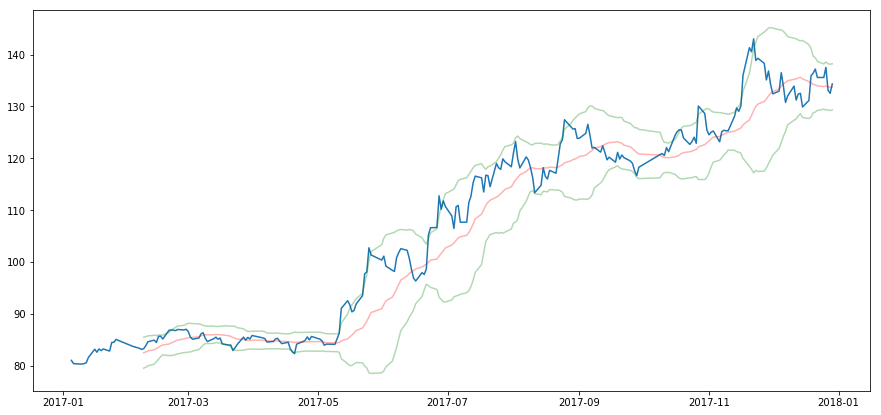

In [4]:
#布林带
data_B= ta.abstract.BBANDS(data, timeperiod=20, price='600036.SH')

plt.figure(figsize=(15,7))
plt.plot(data['600036.SH'])
plt.plot(data_B['middleband'], 'r', alpha=0.3)
plt.plot(data_B['upperband'], 'g', alpha=0.3)
plt.plot(data_B['lowerband'], 'g', alpha=0.3)
plt.show()

In [5]:
high = change_index(dv.get_ts('high_adj').loc[20170105:])['600036.SH']
low = change_index(dv.get_ts('low_adj').loc[20170105:])['600036.SH']

In [6]:
stock = pd.concat([high,low,data['600036.SH']],axis=1)
stock.columns=['high','low','close']

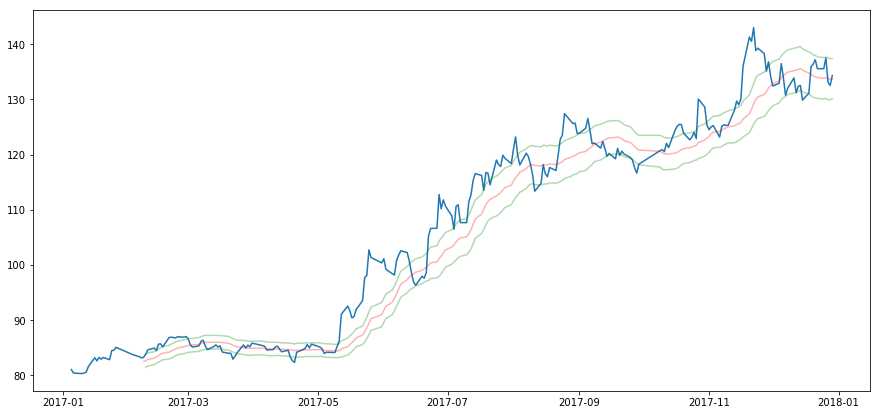

In [7]:
#平均波幅率通道线
atr = ta.abstract.ATR(stock, 20)
middleband = ta.abstract.MA(data, 20, price='600036.SH')
upperband = middleband + atr
lowerband = middleband - atr
data_B = pd.concat([middleband, upperband, lowerband], axis=1)
data_B.columns = ['middleband', 'upperband', 'lowerband']

plt.figure(figsize=(15,7))
plt.plot(data['600036.SH'])
plt.plot(data_B['middleband'], 'r', alpha=0.3)
plt.plot(data_B['upperband'], 'g', alpha=0.3)
plt.plot(data_B['lowerband'], 'g', alpha=0.3)
plt.show()

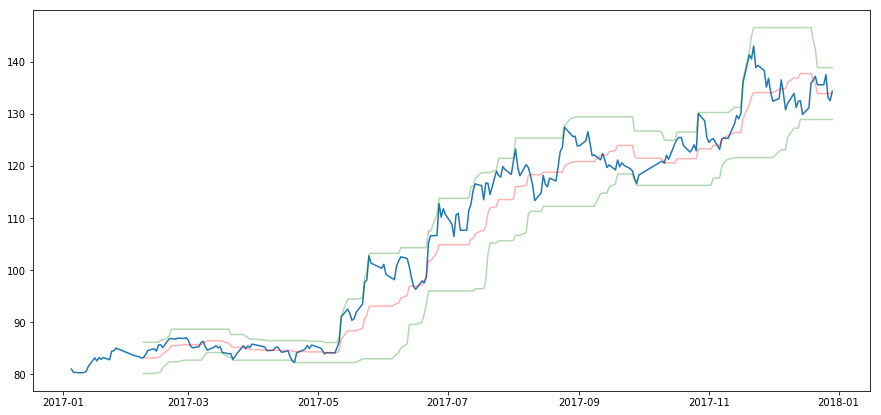

In [8]:
#高低价通道
upperband = ta.abstract.MAX(stock, 20, price='high')
lowerband = ta.abstract.MIN(stock, 20, price='low')
middleband = (upperband+lowerband)/2
data_B = pd.concat([middleband, upperband, lowerband], axis=1)
data_B.columns = ['middleband', 'upperband', 'lowerband']

plt.figure(figsize=(15,7))
plt.plot(data['600036.SH'])
plt.plot(data_B['middleband'], 'r', alpha=0.3)
plt.plot(data_B['upperband'], 'g', alpha=0.3)
plt.plot(data_B['lowerband'], 'g', alpha=0.3)
plt.show()

## 如何用通道构建策略？
### 1. Bollinger Band

Buy： 价格突破UpperBand 和 Sigma<0.005

Sell： b%>0.05

### 2. ATR Band

Buy ： 价格突破upperBand

Sell: 价格跌穿lowerband

In [13]:
# Bollinger Band
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy.ctaBarManager import (CtaTemplate,
                                                     ArrayManager)
import talib as ta


########################################################################
class BBandStrategy(CtaTemplate):
    className = 'BBandStrategy'
    author = 'xingetouzi'


    # 策略参数
    bBandPeriod = 60
    lots = 1
    stopRatio = 0.08  # 止损比例

    # 策略变量
    transactionPrice = {}
    up = {};up1={};up2={}
    mid= {}
    down= {}
    close1={};close2={}
    # 参数列表，保存了参数的名称
    paramList = ['className',
                 'author',
                 'symbolList',
                 'bBandPeriod',
                 'lots',
                 'stopRatio']

    # 变量列表，保存了变量的名称
    varList = ['transactionPrice',
               'maTrend',
               'up','up1','up2',
               'mid',
               'down',
              'close1','close2']

    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    # ----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super(BBandStrategy, self).__init__(ctaEngine, setting)

    # ----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.setArrayManagerSize(self.bBandPeriod * 4)
        self.transactionPrice = {s: 0 for s in self.symbolList}
        self.up1={s: 0 for s in self.symbolList}
        self.up2={s: 0 for s in self.symbolList}
        self.close1={s: 0 for s in self.symbolList}
        self.close2={s: 0 for s in self.symbolList}
        self.putEvent()  # putEvent 能刷新策略UI界面的信息

    # ----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.putEvent()
        '''
        实盘在点击启动策略时, 此时的引擎下单逻辑改为True, 此时开始推送到onbar的数据, 会触发下单。
        '''

    # ----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.putEvent()

    # ----------------------------------------------------------------------
    def onRestore(self):
        """恢复策略（必须由用户继承实现）"""
        # 策略恢复会自动读取 varList 和 syncList 的数据，还原之前运行时的状态。
        # 需要注意的是，使用恢复，策略不会运行 onInit 和 onStart 的代码，直接进入行情接收阶段
        self.putEvent()

    # ----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        # 在每个Tick推送过来的时候,进行updateTick,生成分钟线后推送到onBar.
        # 需要注意的是，如果没有updateTick，实盘将不会推送1分钟K线
        pass

    # ----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.onBarExecute(bar)
        self.onBarRiskControl(bar)

    def onBarRiskControl(self, bar):
        symbol = bar.vtSymbol
        self.writeCtaLog(u'Bar%s'%(bar.__dict__))
        
        # 持有多头仓位
        if self.posDict[symbol + "_LONG"] > 0:
            if (bar.close < self.transactionPrice[symbol] * (1 - self.stopRatio)) or \
                    (bar.close > self.transactionPrice[symbol] * (1 + 2 * self.stopRatio)) :
                self.sell(symbol, bar.close * 0.98, self.posDict[symbol + "_LONG"])

        # 持有空头仓位
        elif self.posDict[symbol + "_SHORT"] > 0:
            if (bar.close > self.transactionPrice[symbol] * (1 + self.stopRatio)) or \
                    (bar.close < self.transactionPrice[symbol] * (1 - 2 * self.stopRatio)) :
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])

        self.putEvent()  # 每分钟更新一次UI界面

    def onBarExecute(self, bar):
        symbol = bar.vtSymbol
        am = self.getArrayManager(symbol, "1m")

        if not am.inited:
            return
        self.close1[symbol]=am.close[-1]
        self.close2[symbol]=am.close[-2]        


        sigma = (self.up1[symbol] -  self.close1[symbol]) / (2 *  self.close1[symbol])
        upsignal = self.close2[symbol] <= self.up2[symbol] and self.close1[symbol] >= self.up1[symbol]

        
        
        if upsignal and sigma < 0.005:
            if self.posDict[symbol + "_SHORT"] > 0:
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])
            elif self.posDict[symbol + "_LONG"] == 0:
                self.buy(symbol, bar.close * 1.02, self.lots)
        if sigma>0.05:
            if self.posDict[symbol + "_LONG"] > 0:
                self.sell(symbol, bar.close * 0.98, self.posDict[symbol + "_LONG"])
            elif self.posDict[symbol + "_SHORT"] == 0:
                self.short(symbol, bar.close * 0.98, self.lots)
                
        self.putEvent()  # 每分钟更新一次UI界面


    def on15MinBar(self, bar):
        """15分钟K线推送"""
        symbol = bar.vtSymbol

        am15 = self.getArrayManager(symbol, "15m")

        if not am15.inited:
            return

        self.up, self.mid, self.low = ta.BBANDS(am15.close, self.bBandPeriod, matype=0)  # parameter1
        self.up1[symbol]=self.up[-1]
        self.up2[symbol]=self.up[-2]        


    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass

    # ----------------------------------------------------------------------
    def onTrade(self, trade):
        symbol = trade.vtSymbol
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onTrade
        self.transactionPrice[symbol] = trade.price

    # ----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function BBandStrategy.onBar at 0x000002614A4D08C8>, <__main__.BBandStrategy object at 0x000002614AC08828>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function BBandStrategy.on15MinBar at 0x000002614A4D06A8>, <__main__.BBandStrategy object at 0x000002614AC08828>)
2018-11-28 12:01:56.217439	开始回测
2018-11-28 12:01:56.217439	策略初始化
2018-11-28 12:01:56.221437	载入历史数据。数据范围:[20180923 04:00,20181001 12:00)
2018-11-28 12:02:28.783634	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-28 12:02:28.803625	载入完成，数据量：12000
2018-11-28 12:02:28.803625	策略初始化完成
2018-11-28 12:02:28.804622	策略启动完成
2018-11-28 12:02:28.804622	开始回放回测数据,回测范围:[20181001 12:00,20181031 16:00)
2018-11-28 12:02:28.810618	载入历史数据。数据范围:[20181001 12:00,20181031 16:00)
2018-11-28 12:03:06.297839	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-28 12:03:06.394769	载入完成，数据量：42270
2018-11-28 12:03:06.394769	当前回放数据

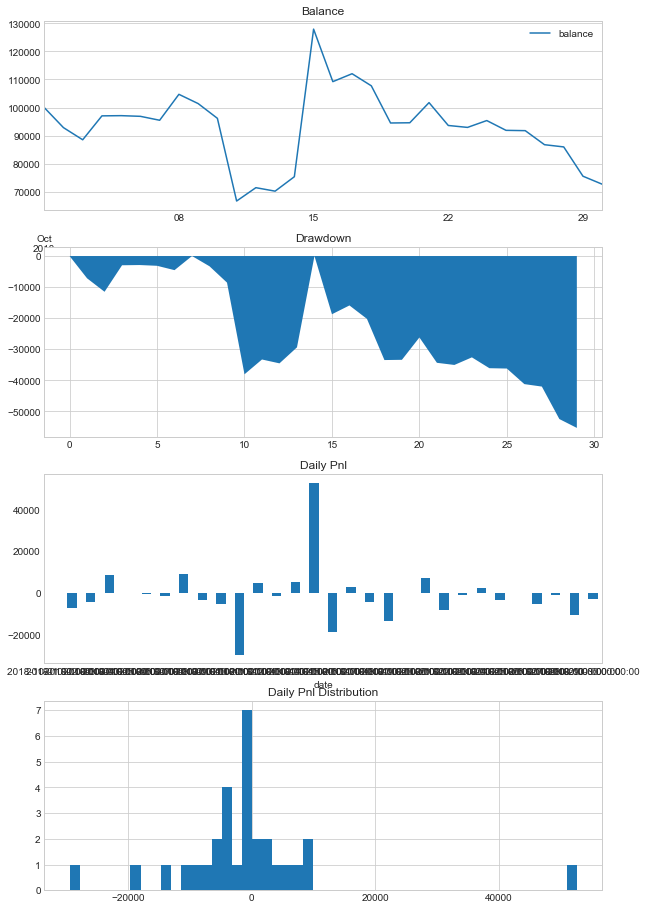

2018-11-28 12:04:53.743087	计算回测结果
2018-11-28 12:04:53.787056	交割单已生成
2018-11-28 12:04:53.787056	------------------------------
2018-11-28 12:04:53.787056	第一笔交易：	2018-10-30 23:58:00
2018-11-28 12:04:53.787056	最后一笔交易：	2018-10-30 23:58:00
2018-11-28 12:04:53.787056	总交易次数：	1
2018-11-28 12:04:53.787056	总盈亏：	-27,664.91
2018-11-28 12:04:53.787056	最大回撤: 	-27,664.91
2018-11-28 12:04:53.787056	平均每笔盈利：	-27,664.91
2018-11-28 12:04:53.787056	平均每笔滑点：	0.0
2018-11-28 12:04:53.787056	平均每笔佣金：	648.91
2018-11-28 12:04:53.788056	胜率		0.0%
2018-11-28 12:04:53.788056	盈利交易平均值	0
2018-11-28 12:04:53.788056	亏损交易平均值	-27,664.91
2018-11-28 12:04:53.788056	盈亏比：	-0.0
2018-11-28 12:04:54.094881	交易记录没有达到10笔！
2018-11-28 12:04:54.095879	计算按日统计结果


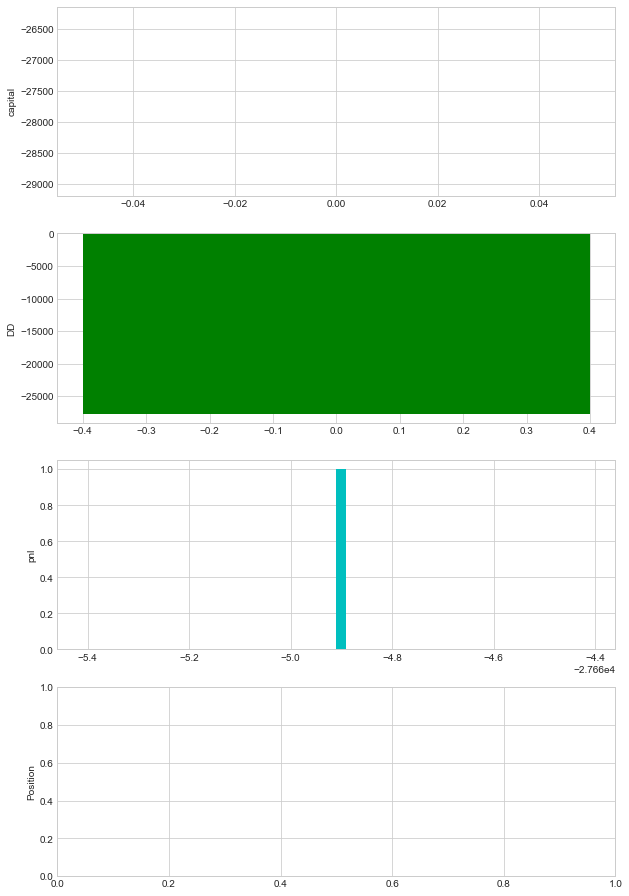

In [15]:
from vnpy.trader.app.ctaStrategy.ctaBarManager import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, size, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSize(size)          # 设置合约大小
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.setLog(True, 'E://log//')
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

if __name__ == '__main__':
    # 同时传入信号与执行的数据
    performanceReport, tradeReport = \
        runBacktesting(BBandStrategy, {'symbolList': ['BTCUSDT:binance']},
                       '20181001 12:00', '20181031 16:00', 100, 0, 5/10000)
    # tradeReport.to_excel('BBandStrategyReport.xlsx')

In [17]:
#ATR_Channel_1

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy.ctaBarManager import (CtaTemplate,
                                                     ArrayManager)
import talib as ta


########################################################################
class ATRBandStrategy(CtaTemplate):
    className = 'ATRBandStrategy'
    author = 'xingetouzi'


    # 策略参数

    ABandPeriod = 60
    lots = 1
    stopRatio = 0.08  # 止损比例

    # 策略变量
    signal = {}  # 
    transactionPrice = {}

    # 参数列表，保存了参数的名称
    paramList = ['className',
                 'author',
                 'symbolList',
                 'ABandPeriod',
                 'lots',
                 'stopRatio']

    # 变量列表，保存了变量的名称
    varList = ['transactionPrice',
              'signal']

    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    # ----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super(ATRBandStrategy, self).__init__(ctaEngine, setting)

    # ----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.setArrayManagerSize(self.ABandPeriod * 4)
        self.transactionPrice = {s: 0 for s in self.symbolList}
        self.signal={s: 0 for s in self.symbolList}
        self.putEvent()  # putEvent 能刷新策略UI界面的信息

    # ----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.putEvent()
        '''
        实盘在点击启动策略时, 此时的引擎下单逻辑改为True, 此时开始推送到onbar的数据, 会触发下单。
        '''

    # ----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.putEvent()

    # ----------------------------------------------------------------------
    def onRestore(self):
        """恢复策略（必须由用户继承实现）"""
        # 策略恢复会自动读取 varList 和 syncList 的数据，还原之前运行时的状态。
        # 需要注意的是，使用恢复，策略不会运行 onInit 和 onStart 的代码，直接进入行情接收阶段
        self.putEvent()

    # ----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        # 在每个Tick推送过来的时候,进行updateTick,生成分钟线后推送到onBar.
        # 需要注意的是，如果没有updateTick，实盘将不会推送1分钟K线
        pass

    # ----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        self.writeCtaLog(u'%s, bar.close%s, %s' % (symbol, bar.close, bar.datetime))  # 可以将实盘的运行情况记录到日志里

        # 持有多头仓位
        if self.posDict[symbol + "_LONG"] > 0:
            if (bar.close < self.transactionPrice[symbol] * (1 - self.stopRatio)) or \
                    (bar.close > self.transactionPrice[symbol] * (1 + 2 * self.stopRatio)):
                self.sell(symbol, bar.close * 0.98, self.posDict[symbol + "_LONG"])

        # 持有空头仓位
        elif self.posDict[symbol + "_SHORT"] > 0:
            if (bar.close > self.transactionPrice[symbol] * (1 + self.stopRatio)) or \
                    (bar.close < self.transactionPrice[symbol] * (1 - 2 * self.stopRatio)):
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])

        self.putEvent()  # 每分钟更新一次UI界面

    def on15MinBar(self, bar):
        """15分钟K线推送"""
        symbol = bar.vtSymbol

        am15 = self.getArrayManager(symbol, "15m")

        if not am15.inited:
            return

        MA = ta.SMA(am15.close, self.ABandPeriod)
        atr = ta.ATR(am15.high, am15.low, am15.close, timeperiod=self.ABandPeriod)
        upperband = MA[-1] + atr[-1]
        lowerband = MA[-1] - atr[-1]
        if bar.close > upperband:
            self.signal[symbol]=1
        elif bar.close < lowerband:
            self.signal[symbol]=-1
        
        if self.signal[symbol]==1:
            if self.posDict[symbol + "_SHORT"] > 0:
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])
            elif self.posDict[symbol + "_LONG"] == 0:
                self.buy(symbol, bar.close * 1.02, self.lots)
        if self.signal[symbol]==-1:
            if self.posDict[symbol + "_LONG"] > 0:
                self.sell(symbol, bar.close * 0.98, self.posDict[symbol + "_LONG"])
            elif self.posDict[symbol + "_SHORT"] == 0:
                self.short(symbol, bar.close * 0.98, self.lots)

    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass

    # ----------------------------------------------------------------------
    def onTrade(self, trade):
        symbol = trade.vtSymbol
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onTrade
        self.transactionPrice[symbol] = trade.price

    # ----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function ATRBandStrategy.onBar at 0x000002614D611D08>, <__main__.ATRBandStrategy object at 0x0000026148DA6A58>)
[DEBUG] 注册品种BTCUSDT:binance上的on_15Min_bar函数functools.partial(<function ATRBandStrategy.on15MinBar at 0x000002614D611400>, <__main__.ATRBandStrategy object at 0x0000026148DA6A58>)
2018-11-28 12:10:12.534651	开始回测
2018-11-28 12:10:12.534651	策略初始化
2018-11-28 12:10:12.536650	载入历史数据。数据范围:[20180923 04:00,20181001 12:00)
2018-11-28 12:10:44.866372	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-28 12:10:44.891354	载入完成，数据量：12000
2018-11-28 12:10:44.892355	策略初始化完成
2018-11-28 12:10:44.893356	策略启动完成
2018-11-28 12:10:44.893356	开始回放回测数据,回测范围:[20181001 12:00,20181031 16:00)
2018-11-28 12:10:44.906349	载入历史数据。数据范围:[20181001 12:00,20181031 16:00)
2018-11-28 12:11:24.115040	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-28 12:11:24.171009	载入完成，数据量：42270
2018-11-28 12:11:24.17100

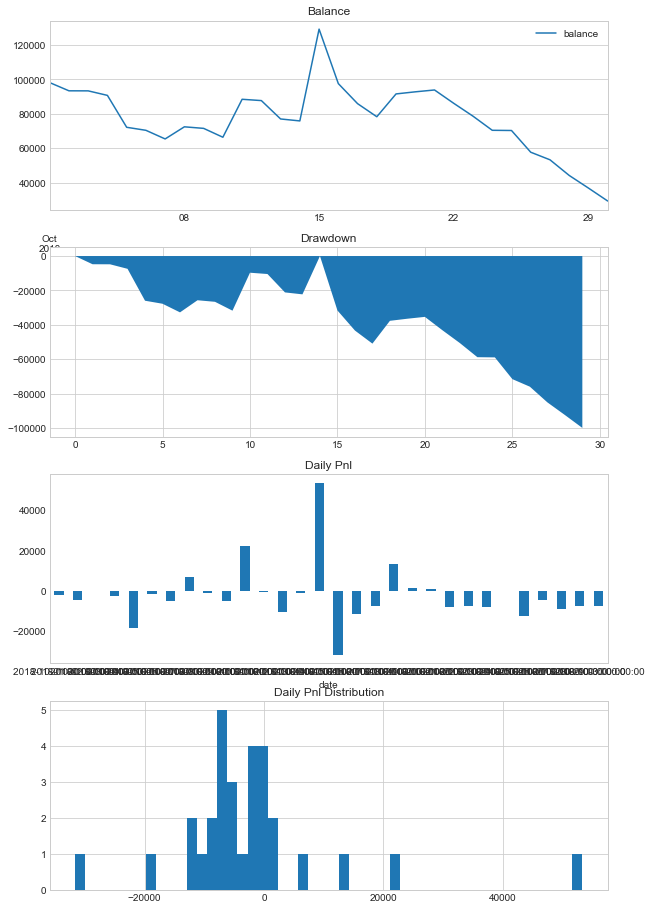

2018-11-28 12:12:50.067905	计算回测结果
2018-11-28 12:12:50.093888	交割单已生成
2018-11-28 12:12:50.093888	------------------------------
2018-11-28 12:12:50.094889	第一笔交易：	2018-10-01 16:00:00
2018-11-28 12:12:50.094889	最后一笔交易：	2018-10-30 23:58:00
2018-11-28 12:12:50.094889	总交易次数：	66
2018-11-28 12:12:50.094889	总盈亏：	-70,977.01
2018-11-28 12:12:50.094889	最大回撤: 	-144,754.32
2018-11-28 12:12:50.094889	平均每笔盈利：	-1,075.41
2018-11-28 12:12:50.094889	平均每笔滑点：	0.0
2018-11-28 12:12:50.095887	平均每笔佣金：	656.52
2018-11-28 12:12:50.095887	胜率		19.7%
2018-11-28 12:12:50.095887	盈利交易平均值	13,684.77
2018-11-28 12:12:50.095887	亏损交易平均值	-4,695.83
2018-11-28 12:12:50.095887	盈亏比：	2.91
2018-11-28 12:12:51.741951	策略回测统计图已保存


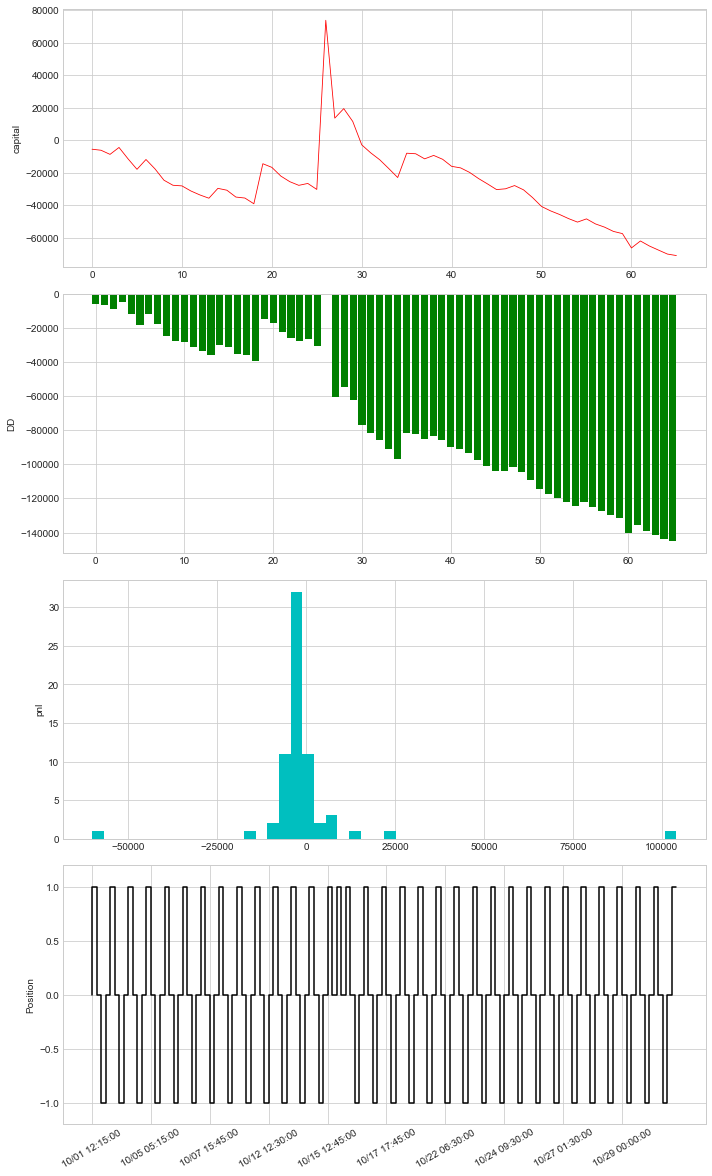

2018-11-28 12:12:52.596466	计算按日统计结果


In [18]:
from vnpy.trader.app.ctaStrategy.ctaBarManager import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, size, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSize(size)          # 设置合约大小
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.setLog(True, 'E://log//')
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

if __name__ == '__main__':
    # 同时传入信号与执行的数据
    performanceReport, tradeReport = \
        runBacktesting(ATRBandStrategy, {'symbolList': ['BTCUSDT:binance']},
                       '20181001 12:00', '20181031 16:00', 100, 0, 5/10000)
    # tradeReport.to_excel('ATRBandStrategyReport.xlsx')

# 作业：
写一个高低价通道突破策略